In [74]:
from pprint import pprint
from os import listdir
from os.path import join

import numpy as np
from scipy.spatial import distance_matrix
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


data_path = join(".", "data")
sample_simulation_path = join(data_path, "realistic_scenario123456")

pprint(listdir(sample_simulation_path))

['ORDERBOOK_SYM2_FULL_transacted_orders.csv',
 'ORDERBOOK_SYM1_FULL_transacted_orders.csv',
 'ORDERBOOK_ETF_FULL_transacted_orders.csv',
 'ORDERBOOK_SYM3_FULL_cleaned_orderbook.csv',
 'ORDERBOOK_ETF_FULL_cleaned_orderbook.csv',
 'ORDERBOOK_SYM3_FULL_transacted_orders.csv',
 'ORDERBOOK_SYM1_FULL_cleaned_orderbook.csv',
 'ORDERBOOK_SYM1_FULL_processed_orderbook.csv',
 'ORDERBOOK_ETF_FULL_processed_orderbook.csv',
 'ORDERBOOK_SYM3_FULL_processed_orderbook.csv',
 'plots',
 'ORDERBOOK_SYM2_FULL_processed_orderbook.csv',
 'ORDERBOOK_SYM2_FULL_cleaned_orderbook.csv']


In [75]:
symbols_names = ["ETF", "SYM1", "SYM2", "SYM3"]
rows_to_drop = 5000
mid_prices, transacted_volumes = {}, {}
for symbol_name in symbols_names:
    orderbook, orderbook_transacted = pd.read_csv(join(sample_simulation_path, f"ORDERBOOK_{symbol_name}_FULL_processed_orderbook.csv")).rename(columns={'index': 'time'}), \
                                      pd.read_csv(join(sample_simulation_path, f"ORDERBOOK_{symbol_name}_FULL_transacted_orders.csv")).rename(columns={'index': 'time'})
    mid_prices[symbol_name], transacted_volumes[symbol_name] = orderbook["MID_PRICE"].values[rows_to_drop:], \
                                                               orderbook_transacted["SIZE"].values[rows_to_drop:]
print(mid_prices)

{'ETF': array([1001.09, 1001.09, 1001.09, ...,  999.5 ,  999.5 ,  999.5 ]), 'SYM1': array([1000.475, 1000.475, 1000.475, ...,  998.905,  998.905,  998.905]), 'SYM2': array([1000.155, 1000.155, 1000.155, ...,  998.055,  998.055,  998.055]), 'SYM3': array([ 999.9 ,  999.9 ,  999.9 , ..., 1005.25, 1005.25, 1005.25])}


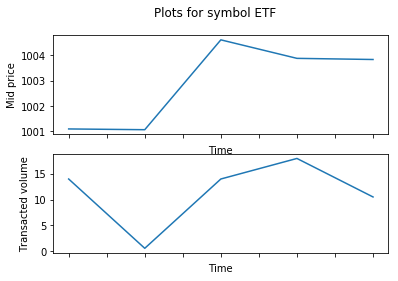

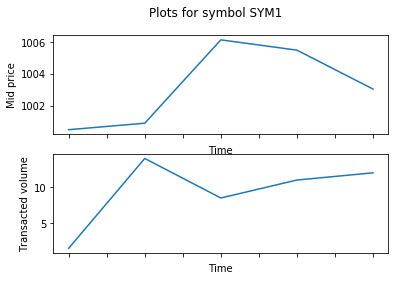

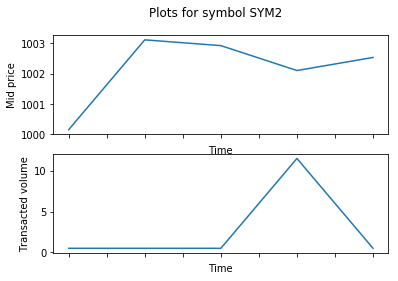

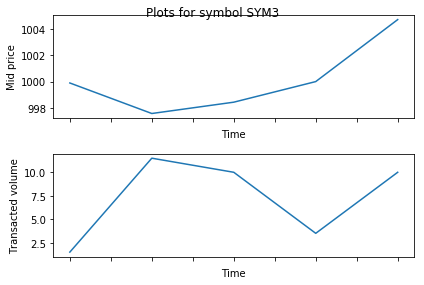

In [76]:
sample_indexes = np.linspace(start=0, stop=mid_prices["ETF"].shape[0] - rows_to_drop, num=5,
                             endpoint=False, dtype=np.int)
sample_indexes_transacted = np.linspace(start=0, stop=transacted_volumes["ETF"].shape[0] - rows_to_drop, num=5,
                             endpoint=False, dtype=np.int)

for symbol_name in symbols_names:
    fig, ax = plt.subplots(2)
    fig.suptitle(f'Plots for symbol {symbol_name}')
    mid_price_ax = sns.lineplot(data=mid_prices[symbol_name][sample_indexes],
                                ax=ax[0])
    mid_price_ax.set(xticklabels=[], xlabel="Time", ylabel="Mid price")

    size_ax = sns.lineplot(data=transacted_volumes[symbol_name][sample_indexes_transacted],
                             ax=ax[1])
    size_ax.set(xticklabels=[], xlabel="Time", ylabel="Transacted volume")
plt.tight_layout()

In [77]:
def get_manifold(*time_series, plot=True):
    # eventually unpacks the list
    if len(time_series) == 1:
        time_series = time_series[0]
    # checks that there are at least two symbols to compare
    assert len(time_series) > 1
    for i_symbol, time_serie in enumerate(time_series):
        # checks that the input is a valid numpy array
        assert isinstance(time_serie, np.ndarray)
        # checks that the shapes of each symbol must match with the others
        assert len(time_serie.shape) == 1
        if i_symbol > 0:
            assert time_series[i_symbol].shape == time_series[i_symbol-1].shape
    manifold = np.stack(time_series, axis=1)

    # eventually plot the manifold
    if plot:
        dimensions = manifold.shape[-1]
        # 2d plots are not working
        # if dimensions == 2:
        #     fig = plt.figure()
        #     ax = fig.add_subplot(111)
        #     ax.plot(xs=time_series[0], ys=time_series[1])
        #     plt.show()
        if dimensions == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot(xs=manifold[:, 0], ys=manifold[:, 1], zs=manifold[:, 2])
            plt.show()
    return manifold

def PC(*time_series, E=3, tau=1):
    # eventually unpacks the list
    if len(time_series) == 1:
        time_series = time_series[0]
    # checks that there are at least two symbols to compare
    assert len(time_series) > 1
    for i_symbol, time_serie in enumerate(time_series):
        # checks that the input is a valid numpy array
        assert isinstance(time_serie, np.ndarray)
        # checks that the shapes of each symbol must match with the others
        assert len(time_serie.shape) == 1
        if i_symbol > 0:
            assert time_series[i_symbol].shape == time_series[i_symbol-1].shape

    attractor = get_manifold(time_series)
    manifolds = [get_manifold([time_serie[e*tau:-((E-e-1)*tau) if E-e-1 != 0 else None]
                               for e in range(E)], plot=False)
                  for time_serie in time_series]
    s = [(manifold[:, :-1] - manifold[:, 1:]) / manifold[:, 1:] for manifold in manifolds]
    distances = distance_matrix(manifolds[0], manifolds[0], p=1)
    print(distances)
    print(distances.shape)

    #w = [np.exp(np.abs()) for manifold in manifolds]
    print("Ok")

PC([mid_prices[symbol_name][sample_indexes] for symbol_name in symbols_names])


[[0.    4.305 7.105]
 [4.305 0.    4.32 ]
 [7.105 4.32  0.   ]]
(3, 3)
Ok
